### **本节将前面神经网络的理论进行应用**


由前面知道学习算法的**基本流程**为： 

**前提**  
神经网络存在合适的权重和偏置，**调整权重和偏置**以便拟合训练数据的  
过程称为“学习”。神经网络的学习分成下面**4个步骤**。  

**步骤1（mini-batch）**  
(推荐自己框架的所有函数应该兼容批处理)  
从训练数据中随机选出一部分数据，这部分数据称为**mini-batch**。我们  
的目标是**减小mini-batch的损失函数的值**。

**步骤2（计算梯度）**  
为了减小mini-batch的损失函数的值，需要求出各个权重参数的梯度。
梯度表示损失函数的值减小最多的方向。

**步骤3（更新参数）**  
将权重参数沿梯度方向进行微小更新

**步骤4（重复）**  
重复步骤1、步骤2、步骤3

***

**应用一：两层神经网络的类**

In [9]:
# 导入必要包及框架
import numpy as np
import my_frame as mf
import gradient as gd # 导入作者的梯度法
from mnist import load_mnist # 导入数据集加载函数

class TwoLayerNet:
    """两层神经网络"""

    def __init__(self,input_size,hidden_size,output_size,
                 weight_init_std = 0.01):
        """神经网络初始化,weight_init_std为我目前未知参数"""

        self.params = {} # 将网络以字典形式存储

        # 随机生成权重矩阵，对偏置矩阵置零
        self.params['W1'] = weight_init_std* \
            np.random.randn(input_size,hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std* \
            np.random.randn(hidden_size,output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self,x):
        """神经网络的推理过程,又称前向传播; x为输入矩阵"""

        # 获取权重及偏置矩阵
        W1,W2 = self.params['W1'],self.params['W2']
        b1,b2 = self.params['b1'],self.params['b2']

        # 前向传播
        a1 = np.dot(x,W1) + b1
        z1 = mf.sigmoid(a1)
        a2 = np.dot(z1,W2) + b2
        y = mf.softmax(a2)

        return y
    
    def loss(self,x,t):
        """神经网络的损失函数计算;x为输入矩阵,t为监督数据矩阵"""

        y = self.predict(x) # 调用推理模块
        return mf.cross_entropy_error(y,t) # 计算交叉熵损失值
    
    def accuracy(self,x,t):
        """估计识别精度;x为输入矩阵,t为监督数据矩阵(兼容one_hot与非one_hot)"""

        y = self.predict(x)
        y = np.argmax(y,axis = 1) # 仅取每个图像的最大可能的结果
        if t.size != y.size: # 如果是one_hot格式的（注意size的用法）
            t = np.argmax(t,axis = 1)
        
        accuracy = np.sum(y == t)/float(x.shape[0]) # 计算识别精度
        return accuracy
    
    def numerical_gradient(self,x,t):
        """计算权重矩阵及偏置矩阵的梯度;x为输入矩阵,t为监督数据矩阵"""

        loss_W = lambda W:self.loss(x,t) # 简化函数定义

        grads = {} # 为与params对应，梯度也用字典形式存储
        # grads['W1'] = mf.numerical_gradient_2d() 我的数值微分梯度法太慢，为加快效率采用误差反向传播法，还不会
        # 仍采用数值微分法，不过是作者的改进过的了
        grads['W1'] = gd.numerical_gradient(loss_W,self.params['W1'])
        grads['b1'] = gd.numerical_gradient(loss_W,self.params['b1'])
        grads['W2'] = gd.numerical_gradient(loss_W,self.params['W2'])
        grads['b2'] = gd.numerical_gradient(loss_W,self.params['b2'])

        return grads


**应用二：基于MNIST手写数字数据集的mini-batch的实现**

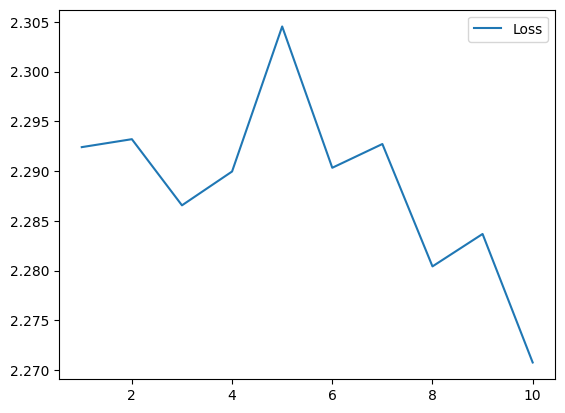

In [15]:
import matplotlib.pyplot as plt # 再导入一个绘图库

# 加载数据集
(x_train,t_train),(x_test,t_test) = load_mnist(flatten = True,one_hot_label = True)

# 设置超参数
iters_num = 10 # mini-batch迭代次数
train_size = x_train.shape[0]
batch_size = 100 # 定义batch为100
learning_rate = 0.1 # 梯度下降算法的学习速率
network = TwoLayerNet(input_size = 784,hidden_size = 50,output_size = 10) # 隐藏层大小设置合适的

# 学习过程记录列表
train_loss_list = []

# 利用训练集进行学习
for i in range(iters_num):
    # 根据batch_size获取batch
    batch_mask = np.random.choice(train_size,batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 计算梯度
    grads = network.numerical_gradient(x_batch,t_batch)
    # grad = network.gradient(x_batch, t_batch) # 高速版!(误差反向传播法)

    # 更新参数
    for key in ('W1','b1','W2','b2'):
        network.params[key] -= learning_rate*grads[key]

    # 记录学习过程
    loss = network.loss(x_batch,t_batch)
    train_loss_list.append(loss)
    print(f"{i+1}th finish!")

x_list = np.arange(1,iters_num+1,1)
plt.plot(x_list,train_loss_list,label = 'Loss')
plt.legend()
plt.show()


可以发现随着学习的进行，**损失函数的值在不断减小**。这是学习**正常进行**的信号，表示神经网络的**权重参数在逐渐拟合数据**。  
也就是说，神经网络的确在**学习**！通过反复地向它浇灌（输入）数据，神经网络正在逐渐向最优参数靠近。

***

**应用三：基于测试数据的评价**

神经网络学习的**最初目标是掌握泛化能力**，因此，要评价神经网络的**泛化能力**，就必须使用不包含在训练数据中的数据。  
下面的代码在进行学习的过程中，会定期地对训练数据和测试数据记录识别精度。  
这里，每经过一个**epoch**，我们都会记录下训练数据和测试数据的识别精度。 

注：**epoch**是一个单位。一个 epoch表示学习中所有训练数据均被使用过  
一次时的更新次数。比如，对于 10000笔训练数据，用大小为 100  
笔数据的mini-batch进行学习时，重复随机梯度下降法 100次，所  
有的训练数据就都被“看过”了。此时，100次就是一个 epoch。  

1th finish!
2th finish!
3th finish!
4th finish!
5th finish!
6th finish!
7th finish!
8th finish!
9th finish!
10th finish!


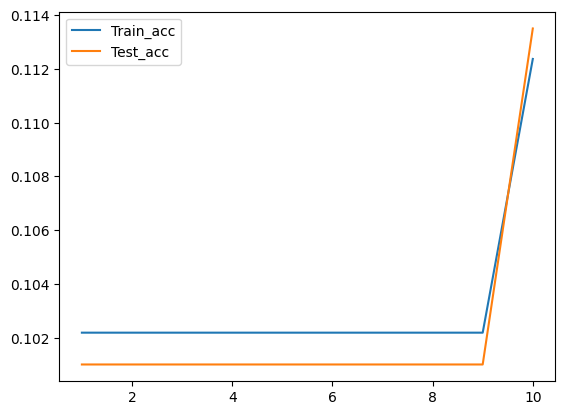

In [15]:
import matplotlib.pyplot as plt # 再导入一个绘图库

# 重新加载数据集
(x_train,t_train),(x_test,t_test) = load_mnist(flatten = True,one_hot_label = True)

# 绘图用到的列表，展示性能
train_loss_list = []
train_acc_list = []
test_acc_list = []

# 设置超参数
iters_num = 10
batch_size = 100
learning_rate = 0.1

# 平均每个epoch的重复次数
train_size = x_train.shape[0]
iter_per_epoch = max(train_size/batch_size,1)

# 初始化神经网络
network = TwoLayerNet(input_size = 784,hidden_size = 50,output_size = 10)

for i in range(iters_num):

    # 获取mini-batch
    batch_mask = np.random.choice(train_size,batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 计算梯度
    grads = network.numerical_gradient(x_batch,t_batch)

    # 更新参数
    for key in ('W1','b1','W2','b2'):
        network.params[key] -= learning_rate*grads[key]
        
    # 计算损失值
    # loss = network.loss(x_batch,t_batch)
    # train_loss_list.append(loss)

    # 计算每个epoch的识别精度
    if i%iter_per_epoch == 0 or True:
        train_acc_list.append(network.accuracy(x_train,t_train))
        test_acc_list.append(network.accuracy(x_test,t_test))
    print(f"{i+1}th finish!")

x_list = np.arange(1,len(train_acc_list)+1,1)
plt.plot(x_list,train_acc_list,label = 'Train_acc')
plt.plot(x_list,test_acc_list,label = 'Test_acc')
plt.legend()
plt.show()

结论：我们发现使用训练数据和测试数据评价的识别精度都提高了，  
并且，这两个识别精度基本上没有差异（两条线基本重叠在一起）。   
因此，可以说这次的学习中**没有发生过拟合**的现象。 